In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

%matplotlib inline

In [2]:
#激活函数
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    s = np.maximum(0,x)
    return s

In [3]:
#数据生成
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #生成两个交错半圈

    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

In [4]:
#参数初始化
def initialize_parameters(layer_dims):
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) 

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*  np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [5]:
#损失计算
def compute_cost(a3, Y):
    
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.sum(logprobs)
    
    return cost

In [6]:
#前向传播
def forward_propagation(X, parameters):

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

In [7]:
#反向传播
def backward_propagation(X, Y, cache):
    
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

In [8]:
#计算精确度
def predict(X, y, parameters):
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    a3, caches = forward_propagation(X, parameters)
    
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("准确度: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [9]:
#画出分界线
def plot_decision_boundary(model, X, y):
    #设置最大最小值
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    #生成各点之间的距离为h的网格
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    #预测
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
  
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def predict_dec(parameters, X):
    
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3 > 0.5)
    
    return predictions   

In [10]:
#直接用梯度更新参数
def update_parameters_with_gd(parameters, grads, learning_rate):

    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads['db' + str(l+1)]
        
    return parameters

In [11]:
#随机小批量
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    np.random.seed(seed)           
    m = X.shape[1]                  
    mini_batches = []
        
    permutation = list(np.random.permutation(m))#生成一个随机排列
    shuffled_X = X[:, permutation]#对X进行重排
    shuffled_Y = Y[:, permutation].reshape((1,m))
    
    num_complete_minibatches = math.floor(m/mini_batch_size)#小批量数
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    #剩余的样本
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,  num_complete_minibatches*mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:,  num_complete_minibatches*mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [12]:
#Momentum参数初始化
def initialize_velocity(parameters):
    
    L = len(parameters) // 2 
    v = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(np.shape(parameters["W" + str(l+1)]))
        v["db" + str(l+1)] = np.zeros(np.shape(parameters["b" + str(l+1)]))
        
    return v

In [13]:
#用Momentum更新参数
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):

    L = len(parameters) // 2 
    
    for l in range(L):
        v["dW" + str(l+1)] = beta*v["dW" + str(l+1)] + (1 - beta)*grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta*v["db" + str(l+1)] + (1 - beta)*grads["db" + str(l+1)]
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v["db" + str(l+1)]
        
    return parameters, v

In [14]:
#Adam参数初始化
def initialize_adam(parameters) :
    
    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(np.shape(parameters["W" + str(l+1)]))
        v["db" + str(l+1)] = np.zeros(np.shape(parameters["b" + str(l+1)]))
        s["dW" + str(l+1)] = np.zeros(np.shape(parameters["W" + str(l+1)]))
        s["db" + str(l+1)] = np.zeros(np.shape(parameters["b" + str(l+1)]))
    
    return v, s

In [15]:
#用Adam法更新参数
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):

    
    L = len(parameters) // 2                
    v_corrected = {}                       
    s_corrected = {}                      
    
    for l in range(L):
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1 - beta1)*grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1 - beta1)*grads["db" + str(l+1)]

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1 - np.power(beta1,l+1))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1 - np.power(beta1,l+1))
    
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1 - beta2)*np.square(grads["dW" + str(l+1)])
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1 - beta2)*np.square(grads["db" + str(l+1)])
        
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1 - np.power(beta2,l+1))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1 - np.power(beta2,l+1))

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)

    return parameters, v, s

In [19]:
#建立整个模型
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):

    L = len(layers_dims)             
    costs = []                       
    t = 0                            
    seed = 10                        

    parameters = initialize_parameters(layers_dims)


    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            a3, caches = forward_propagation(minibatch_X, parameters)
            cost = compute_cost(a3, minibatch_Y)
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        if print_cost and i % 3000 == 0:
            print ("%i epoch之后的成本值: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

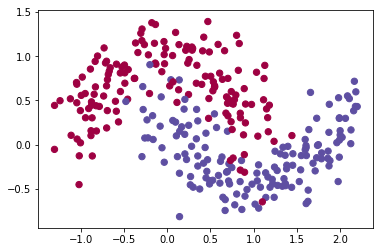

In [18]:
#训练数据
train_X, train_Y = load_dataset()

0 epoch之后的成本值: 0.690736
3000 epoch之后的成本值: 0.619525
6000 epoch之后的成本值: 0.529403
9000 epoch之后的成本值: 0.464518


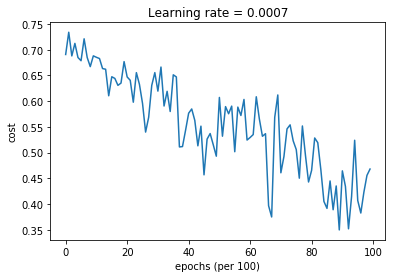

准确度: 0.796666666667


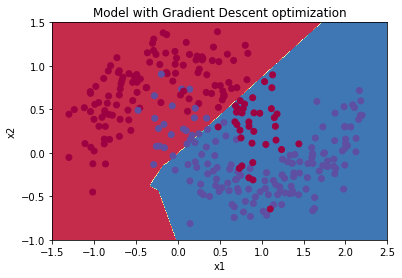

0 epoch之后的成本值: 0.690741
3000 epoch之后的成本值: 0.619594
6000 epoch之后的成本值: 0.529476
9000 epoch之后的成本值: 0.464740


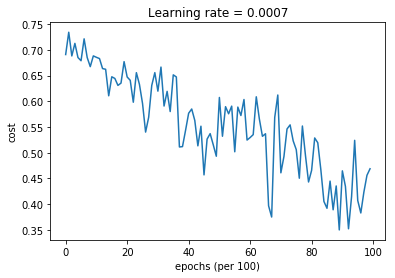

准确度: 0.796666666667


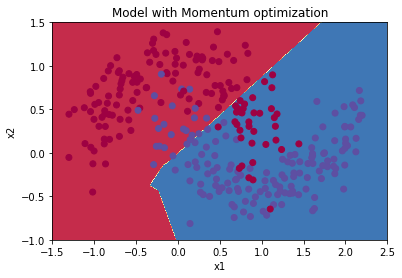

0 epoch之后的成本值: 0.690433
3000 epoch之后的成本值: 0.147159
6000 epoch之后的成本值: 0.127093
9000 epoch之后的成本值: 0.213533


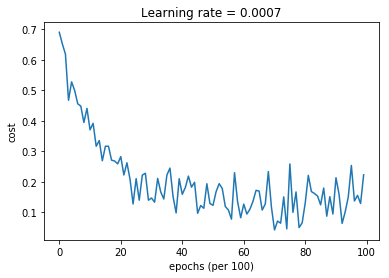

准确度: 0.943333333333


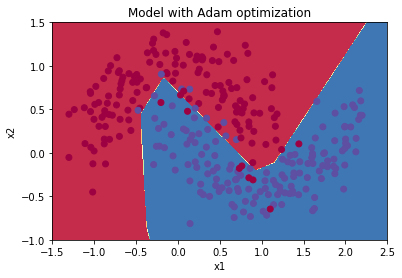

In [20]:
layers_dims = [train_X.shape[0], 5, 2, 1] #神经网络层数

#小批量梯度下降模型
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")
predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)


#Momentum梯度下降模型
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")
predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#Adam梯度下降模型
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")
predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)